In [15]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime as dt
import datetime
from datetime import timedelta
from datetime import date


import re
import time
import stat
import contextlib
import functools

import concurrent.futures
from concurrent.futures import wait, ALL_COMPLETED

from fbprophet import Prophet
import urllib
import urllib.request
import pandas_market_calendars as mcal
import os.path
from os import path
from functools import reduce
#import pandas-datareader
#import mpl-finance
#from fbprophet.diagnostics import cross_validation
#rom fbprophet import Prophet
import stockstats
from stockstats import StockDataFrame
import tabulate
import mplfinance as mpf
import matplotlib.dates as mdates
import statsmodels.tsa.stattools as ts
from hurst import compute_Hc

import os.path
from os import path

pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

from finta import TA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
from sklearn.metrics import mean_squared_error

from scipy.stats import ttest_ind

In [16]:
n_forward = 7

#name = 'GLD'
#name = 'SPY'
#name = 'GOOG'

#strategy = "EMA"
strategy = "SMA"
#indicator = 'Close'
indicator = 'VWP'

w=117
#end_date = datetime.date.today()
end_date = datetime.date.today() - timedelta(weeks=w)
end_date1 = end_date - timedelta(weeks=w)

#- timedelta(weeks=w*2)
start_date = end_date1 - timedelta(weeks=w)

benchName = "^GSPC"
bench = yf.Ticker(benchName)
benchData = bench.history(interval="1d",start=start_date,end=end_date, auto_adjust=True)


In [17]:

dateindex = benchData.loc[start_date:end_date].index
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward+3))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

nyse = mcal.get_calendar('NYSE')
nyse_trading_dates= nyse.schedule(start_date=start_date, end_date=(end_date+timedelta(days=n_forward+3)))



/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.



In [18]:
#if(len(data)==len(dateindex_)):
if(len(benchData)>len(nyse_trading_dates)):
    frequency=pd.DataFrame(dateindex_n_forward).set_index(0)
    
else:
    frequency=nyse_trading_dates.rename_axis([None]).index
    


In [42]:
#will help later with bad data during loops

prices = benchData
df = prices.rename_axis([None]).reindex(frequency)

for d in prices.rename_axis([None]).index:
    df.loc[d] = prices.loc[d]

df = df.interpolate(method='linear')

benchData = df[start_date:end_date]


,Open,High,Low,Close,Volume,Dividends,Stock Splits
2018-07-31,2809.73,2824.46,2808.06,2816.29,3.892100e+09,0.0,0.0
2018-08-01,2821.17,2825.83,2805.85,2813.36,3.496990e+09,0.0,0.0
2018-08-02,2800.48,2829.91,2796.34,2827.22,3.467380e+09,0.0,0.0
2018-08-03,2829.62,2840.38,2827.37,2840.35,3.030390e+09,0.0,0.0
2018-08-06,2840.29,2853.29,2835.98,2850.40,2.874540e+09,0.0,0.0
2018-08-07,2855.92,2863.43,2855.92,2858.45,3.162770e+09,0.0,0.0
2018-08-08,2856.79,2862.44,2853.09,2857.70,2.972200e+09,0.0,0.0
2018-08-09,2857.19,2862.48,2851.98,2853.58,3.047050e+09,0.0,0.0
2018-08-10,2838.90,2842.20,2825.81,2833.28,3.256040e+09,0.0,0.0
2018-08-13,2835.46,2843.40,2819.88,2821.93,3.158450e+09,0.0,0.0


In [45]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)

In [46]:
pd.set_option('display.max_columns', None) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', None) #replace n with the number of rows you want to see completely

cores = int(len(os.sched_getaffinity(0)))

pool1 = concurrent.futures.ProcessPoolExecutor(cores)

one_week_end = start_date
one_week_start = one_week_end - timedelta(weeks=1)

#need to do the two pass trick (i.e. find stocks fully populated a week 9 quarters back)

nyse = mcal.get_calendar('NYSE')
official_trading_dates= nyse.schedule(start_date=start_date, end_date=end_date)

date_time_obj_start = start_date

date_time_obj_end = end_date

one_week_trading_dates = nyse.schedule(start_date=one_week_start, end_date=one_week_end)

url = 'ftp://ftp.nasdaqtrader.com/symboldirectory/nasdaqtraded.txt'

#should turn this into a function
if path.exists("nasdaqtraded.txt"):
    print("file exists")
    
    filePath = 'nasdaqtraded.txt'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading")
        urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
        urllib.request.urlretrieve(url, 'mfundslist.txt')
        urllib.request.urlretrieve(url, 'bonds.txt')
    else:
      print("equal dates, not redownloading")
    
else:
    print("downloading nasdaqtraded.txt")
    urllib.request.urlretrieve(url, 'nasdaqtraded.txt')
    urllib.request.urlretrieve(url, 'mfundslist.txt')
    urllib.request.urlretrieve(url, 'bonds.txt')
    
df1 = pd.read_csv('nasdaqtraded.txt', sep='|')[0:-1]
df2 = pd.read_csv('mfundslist.txt', sep='|')[0:-1]
df3 = pd.read_csv('bonds.txt', sep='|')[0:-1]

#process symbols for bad characters
BAD_CHARS = ['$','.']
pat = '|'.join(['({})'.format(re.escape(c)) for c in BAD_CHARS])

df1 = df1[~df1['Symbol'].str.contains(pat)]
df2 = df2[~df2['Symbol'].str.contains(pat)]
df3 = df3[~df3['Symbol'].str.contains(pat)]

#choose size
size=300
stocks = list(df1["Symbol"].sample(n=int(size/3)))
mfunds = list(df2["Symbol"].sample(n=int(size/3)))
bonds = list(df3["Symbol"].sample(n=int(size/3)))
symbols = unique(stocks + mfunds + bonds)

def dl_one_week(stock):
    return yf.download(stock, start=one_week_start, end=one_week_end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')

def dl(stock):
    return yf.download(stock, start=start_date, end=end_date, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')

def processStocks(symbols):

    futures1 = [pool1.submit(dl_one_week, args) for args in symbols]
    wait(futures1, timeout=None, return_when=ALL_COMPLETED)

    symbols_data_one_week = pd.DataFrame()

    for x in range(0,len(symbols)):
        prices = pd.DataFrame(futures1[x].result())
        prices['Symbol'] = symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        symbols_data_one_week = pd.concat([symbols_data_one_week,prices])

    #symbols_data_one_week

    #stocks that existed 9 quarters ago
    vetted_symbols = list(symbols_data_one_week.Symbol.unique())

    pool2 = concurrent.futures.ProcessPoolExecutor(cores)

    futures2 = [pool2.submit(dl, args) for args in vetted_symbols]
    wait(futures2, timeout=None, return_when=ALL_COMPLETED)    

    symbols_data = pd.DataFrame()
    
    #Have to interpolate later
    for x in range(0,len(vetted_symbols)):
        prices = pd.DataFrame(futures2[x].result())
        prices['Symbol'] = vetted_symbols[x]
        prices = prices.loc[~prices.index.duplicated(keep='last')]        
        prices = prices.reset_index()

        #idx1 = prices.index  
        
        #df = prices.rename_axis([None]).reindex(frequency)

        #for d in prices.rename_axis([None]).index:
            #df.loc[d] = prices.loc[d]

        #df.interpolate(method='linear')
        
        #merged = idx1.union(frequency)
        #s = prices.reindex(merged)
        #df = s.interpolate().dropna(axis=0, how='any')

        #if len(df) == len(prices.index):
        symbols_data = pd.concat([symbols_data,prices])
            
    symbols_data.to_csv('symbols_data.csv', index = False)

if path.exists('symbols_data.csv'):
    print("data exists")
    
    filePath = 'symbols_data.csv'
    fileStatsObj = os.stat ( filePath )
    modificationTime = time.ctime ( fileStatsObj [ stat.ST_MTIME ] )

    print("Last Modified Time : ", modificationTime )

    a = datetime.datetime.strptime(modificationTime, "%a %b %d %H:%M:%S %Y")

    if a.date() != datetime.date.today():
        print("not same dates downloading stocks")
        
        processStocks(symbols)
        
    else:
        print("equal dates, not redownloading")
    
else:
    print("downloading symbols")
    processStocks(symbols)
    


file exists
Last Modified Time :  Mon Mar  8 13:08:20 2021
equal dates, not redownloading
data exists
Last Modified Time :  Mon Mar  8 13:15:32 2021
equal dates, not redownloading


/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.

/usr/local/lib/python3.6/dist-packages/pandas/core/internals/construction.py:791: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning:

This pattern has match groups. To actually get the

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [47]:
#symbols = ['BTC-USD']
#processStocks(symbols)

symbols_data = pd.read_csv('symbols_data.csv', sep=',')[0:-1]
vetted_symbols = symbols_data.Symbol.unique()


In [48]:
symbols_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol'], dtype='object')

In [49]:
returnsdf = pd.DataFrame()
returnsl = []

#cumulative returns of 1st half
for i in vetted_symbols:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[start_date.strftime('%Y-%m-%d'):end_date1.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    #plt.plot(cumulative_ret, label=i)
    #plt.legend(loc="upper left",fontsize=8)
    
returnsdf["returns"] = returnsl
returnsdf["stock"] = vetted_symbols

returnsdf = returnsdf.sort_values(by=['returns'], ascending=False)

XPercent = .1
cutoff = round(len(returnsdf)*XPercent,0)

topXPercent = returnsdf['stock'][0:int(cutoff)]
topXPercent

141    VUZI
89      BMA
100     DPZ
38     TAYD
94      DRD
60     SNEX
96     PPBI
152    MRCY
71      RLI
74     BRID
9      ISRG
4      JBLU
24     SWBI
23      RDI
41      NAT
139    STLD
Name: stock, dtype: object

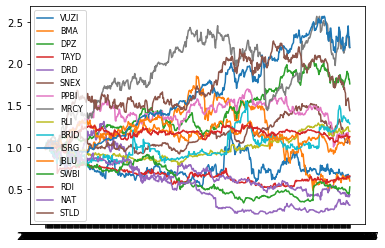

In [50]:
#cumulative returns over test period

for i in topXPercent:
    subset = symbols_data[symbols_data["Symbol"]==i]
    subset = subset.set_index('Date')[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    
    #print(subset)
    price_data = subset["Close"]
    #print(price_data)
    
    ret_data = price_data.pct_change()[1:]
    
    cumulative_ret = (ret_data + 1).cumprod()
    
    last = cumulative_ret.iloc[-1]
    
    #pd.concat(last,returns)
    returnsl.append(last)

    plt.plot(cumulative_ret, label=i)
    plt.legend(loc="upper left",fontsize=8)

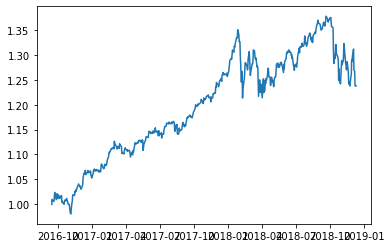

In [51]:
limit = 100

train_size = 0.5

#minExpectedReturn = 0.0005
minExpectedReturn = 0.0

width1 = len(nyse_trading_dates[start_date:end_date1].index)

#not doing any sales here, so is the +1 necessary?
#even if doing +1 I don't want to use timedelta, but it's okay to use it becuase at most it's +1 actual day (vs trading day) and the filtering will still work
#width2 = len(data.loc[end_date1+timedelta(days=1):end_date].index)
width2 = len(nyse_trading_dates[end_date1+timedelta(days=1):end_date].index)


#dateindex = benchData.loc[start_date:end_date].index
#returnsdf[0:int(cutoff)]

dateindex = benchData.loc[start_date:end_date].index
dateindex_ = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date)-start_date).days)]
dateindex_n_forward = [start_date + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-start_date).days)]

#dateindex2 = benchData.loc[end_date1:end_date].index

#dateindex2_n_foward = [end_date1 + datetime.timedelta(days=x) for x in range(0, ((end_date+ timedelta(days=n_forward))-end_date1).days)]

sp500_data = benchData[end_date1+timedelta(days=1):end_date]['Close'].pct_change()
sp500_cumulative_ret_data = (sp500_data + 1).cumprod()
plt.plot(sp500_cumulative_ret_data,label="bench: " + benchName)


In [52]:
len(benchData)
#benchData.iloc[-1]
#len(idx2)

1131

In [53]:
width1

566

In [54]:
width2

565

In [ ]:
#for symbol in [topXPercent.iloc[0]]:
def processSets(symbol):

    subset = symbols_data[symbols_data["Symbol"]==symbol]
    subset = subset.set_index('Date')
    subset['Forward Close'] = subset['Close'].shift(-n_forward)
    subset['Forward Return'] = (subset['Forward Close'] - subset['Close'])/subset['Close']
    subset['VWP'] = subset['Close']*subset['Volume']
    
    Short_EVWMA = pd.DataFrame(TA.EVWMA(subset,12))
    Long_EVWMA = pd.DataFrame(TA.EVWMA(subset,26))
    Short_EVWMA.columns = ['EVWMA_12']
    Long_EVWMA.columns = ['EVWMA_26']

    #p 209 of ttr doc
    MACD_EVWMA = pd.DataFrame((Short_EVWMA['EVWMA_12'] - Long_EVWMA['EVWMA_26'])/Long_EVWMA['EVWMA_26'])
    MACD_EVWMA.columns = ['MACD-line']

    Signal_EVWMA = pd.DataFrame(ta.ema(MACD_EVWMA["MACD-line"], length=9))
    Signal_EVWMA.columns = ['Signal_EMA_9_MACD']
    subset['MACD_Signal'] = Signal_EVWMA
        
    prices = subset.loc[~subset.index.duplicated(keep='last')]        
    
    df = prices.rename_axis([None]).reindex(frequency)

    for d in prices.rename_axis([None]).index:
        df.loc[d] = prices.loc[d]

    df.interpolate(method='linear').dropna(axis=0, how='any')

    subset = df

    #conditions_ = []

    trades2 = pd.DataFrame()
    
    #rolling windows
    #for i in [range(0,width1)[-1]]:
    for i in range(0,width1):
    #def processSet(i):        

        temp = subset.loc[frequency[i].strftime('%Y-%m-%d'):frequency[i+width2].strftime('%Y-%m-%d')].copy()
        #temp = data.loc[frequency[i]:frequency[i+width2]].copy()        

        innerIndicator = 'Close'
        #not sure if kind should be price
        adf_results = ts.adfuller(temp[innerIndicator], 1)

        #makes no sense to do with n_forward
        H, c, val = compute_Hc(temp[innerIndicator], kind='price', simplified=True)            

        fb = True

        if fb:        

            ts1 = pd.DataFrame()
            ts1["Date"] = temp.index
            ts1['y'] = temp[innerIndicator].values
            ts1.columns = ['ds', 'y']

            #no need to strip last day from model becuase df_inner (which ts is based on) is already -2
            m = Prophet(daily_seasonality=True,yearly_seasonality=True)
            m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            m.add_seasonality(name='quarterly', period=91.25, fourier_order=7)
            m.fit(ts1)

            #forecast only last day in model (can verify result) needs to be based on df.loc (similar to df_inner)
            #dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(temp.index[-1], "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
            dateToBeSold = frequency[frequency.get_loc(temp.index[-1])+n_forward].strftime('%Y-%m-%d')
            nextDay = frequency[frequency.get_loc(temp.index[-1]+1)].strftime('%Y-%m-%d')
            #forecast = pd.DataFrame(pd.DataFrame(idx2)[0][(pd.DataFrame(idx2)[0] <= datetime.datetime.strptime(dateToBeSold, "%Y-%m-%d").date()) & (pd.DataFrame(idx2)[0] >= datetime.datetime.strptime(nextDay, "%Y-%m-%d").date())])
            forecast = pd.DataFrame(pd.DataFrame(frequency)[0][(pd.DataFrame(frequency)[0] <= dateToBeSold) & (pd.DataFrame(frequency)[0] >= nextDay)])
            forecast.columns = ['ds']

            #Predict and plot
            pred = m.predict(forecast)['yhat']
            pred = pd.DataFrame(pred)
            pred.columns = [innerIndicator]

        result = []

        for ma_length in range(20,limit):        

            if strategy == "EMA":

                temp[strategy] = ta.ema(temp[indicator], length=ma_length)
                temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]

            elif strategy == "SMA":

                temp[strategy] = temp[indicator].rolling(ma_length).mean()
                temp['input'] = [int(x) for x in temp[indicator] > temp[strategy]]

            df = temp.dropna()

            training = df.head(int(train_size * df.shape[0]))
            test = df.tail(int((1 - train_size) * df.shape[0]))

            tr_returns = training[training['input'] == 1]['Forward Return']
            test_returns = test[test['input'] == 1]['Forward Return']

            mean_forward_return_training = tr_returns.mean()
            mean_forward_return_test = test_returns.mean()
            pvalue = ttest_ind(tr_returns,test_returns,equal_var=False)[1]

            result.append({
                'ma_length':ma_length,
                'training_forward_return': mean_forward_return_training,
                'test_forward_return': mean_forward_return_test,
                'p-value':pvalue
            })

        result.sort(key = lambda x : -x['training_forward_return'])

        if strategy == "EMA":
            temp[strategy] = ta.ema(temp[indicator], length=result[0]['ma_length'])

        elif strategy == "SMA":
            temp[strategy] = temp[indicator].rolling(result[0]['ma_length']).mean()    

        #conditions = 0

        if fb:

            predRet = (pred.iloc[-1][0] - temp.iloc[-1][innerIndicator])/temp.iloc[-1][innerIndicator]
            #print(predRet)

            if predRet >= 0:

                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['fbProphet']
                trade['expRet'] = predRet
                trades2 = pd.concat([trades2,trade])


        if temp.iloc[-1]['MACD_Signal'] > 0:
                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['MACD']
                trade['expRet'] = [temp.iloc[-1]['MACD_Signal']]
                trades2 = pd.concat([trades2,trade])

        #if(n_forward > 1):

            #fit2 = Holt(temp['MACD_Signal'], exponential=False, initialization_method="estimated").fit(optimized=True)
            #fcast2 = fit2.forecast(n_forward).rename("Exponential trend")    

            #if(fcast2[-1] >= .02):
                #conditions = conditions + 1

        #elif (temp.iloc[-1]['MACD_Signal'] >= .02):
            #conditions = conditions + 1

        if (H > 0.5):
                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['H']
                trade['expRet'] = [H]
                trade['sdev'] = ['']
                trades2 = pd.concat([trades2,trade])

        if (adf_results[1] > 0.05):
                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = ['adf']
                trade['expRet'] = [adf_results[1]]
                trade['sdev'] = ['']
                trades2 = pd.concat([trades2,trade])

        if (result[0]['p-value'] > .05 and temp.iloc[-1][indicator]>temp.iloc[-1][strategy]):

            if (result[0]['training_forward_return'] > minExpectedReturn and result[0]['test_forward_return'] > minExpectedReturn):

                trade = pd.DataFrame()
                trade['Date'] = [temp.index[-1]]
                trade['Type'] = [strategy]
                trade['expRet'] = [((result[0]['training_forward_return']+result[0]['test_forward_return'])/2)]
                trade['sdev'] = [np.std(temp['Forward Return'])]
                trades2 = pd.concat([trades2,trade])

                if fb:

                    if predRet >= 0:

                        trade = pd.DataFrame()
                        trade['Date'] = [temp.index[-1]]
                        trade['Type'] = ['fbProphet+strategy']
                        trade['expRet'] = [(predRet + ((result[0]['training_forward_return']+result[0]['test_forward_return'])/2))/2]
                        trade['sdev'] = ['']
                        trades2 = pd.concat([trades2,trade])

        #print(trades2)
        #return trades2
    
    #pool4 = concurrent.futures.ProcessPoolExecutor(cores)

    #futures4 = [pool4.submit(processSet, args) for args in range(0,width1)]

    #wait(futures4, timeout=None, return_when=ALL_COMPLETED)
    
    #print("starting set")
    #trades2 = pd.DataFrame()

    #for f in futures4:
        #throwing a weird date error with one dataframe (had date outside of range)
        #trades2 = pd.concat([trades2,f.result()])

    set = pd.DataFrame()
    for i in range(0,len(trades2)):
        value = pd.DataFrame(subset.loc[trades2.iloc[i]['Date']]).transpose().reset_index(drop=True)
        value['index'] = i
        value['type'] = trades2.iloc[i]['Type']
        value['Date'] = trades2.iloc[i]['Date']
        value['ExpectedReturn'] = [trades2.iloc[i]['expRet']]
        value['sdev'] = trades2.iloc[i]['sdev']
        set = pd.concat([set,value.set_index('index')])

    return set
    #print(set)


pool3 = concurrent.futures.ProcessPoolExecutor(cores)

futures3 = [pool3.submit(processSets, args) for args in topXPercent]

wait(futures3, timeout=None, return_when=ALL_COMPLETED)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: FutureWarning:

Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, u

In [ ]:

BuyFundsPercent = .75
percentHeldOnSell = 1

strategies = []
holds = []

for f in futures3:
    #throwing a weird date error with one dataframe (had date outside of range)
    
    set = pd.DataFrame(f.result()).set_index('Date')[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]
    
    if (len(set) != 0):
        print(set['Symbol'].unique())
        #display(set)
        #print(set)
        #plt.hist(set['sdev'], bins='auto')  # arguments are passed to np.histogram
        #plt.show()
        #plt.hist(set['ExpectedReturn'], bins='auto')  # arguments are passed to np.histogram
        #plt.show()
        #plt.hist(set['Forward Return'], bins='auto')  # arguments are passed to np.histogram
        #plt.show()        

        orderbook = pd.DataFrame()

        #temp = pd.DataFrame([dateToBeSold,1],columns=['date','qty'])
        column_names = ["date", "qty"]

        sellDates = pd.DataFrame(columns = column_names)
        
        data = symbols_data[symbols_data["Symbol"]==set['Symbol'].unique()[0]].set_index('Date')

        #set[dateindex2[1].strftime('%Y-%m-%d')]
        for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:
            #print(i)
        #for i in frequency[frequency.get_loc(end_date1):]:

            idate = i.strftime('%Y-%m-%d')        

            #process purchases
            #set index's are repeated
            if (idate in set.index.unique()):
                print(idate)

                #innerSet = pd.DataFrame(set.set_index('Date').loc[idate]).transpose()
                innerSet = set.loc[idate]

                #if isinstance(innerSet, pd.DataFrame):
                    #print("pd")
                if isinstance(innerSet, pd.Series):
                    #print("series")
                    innerSet = pd.DataFrame(innerSet).transpose()

                #print(innerSet)
                types = innerSet.type.unique()
                #display(innerSet)

                for t in types:
                    innerSet_t = innerSet[innerSet['type']==t]
                    #print(innerSet[innerSet['type']==t])
                    #print(innerSet_t)

                    temp = pd.DataFrame()

                    #estRet = set.set_index('Date').loc[idate]['ExpectedReturn']
                    estRet = innerSet_t.loc[idate]['ExpectedReturn']

                    temp['orderside'] = ['buy']        

                    #if len(data[start_date.strftime('%Y-%m-%d'):idate])-1+n_forward>=len(data[start_date.strftime('%Y-%m-%d'):]):
                        #dateToBesold = np.nan    
                        #dateToBeSold = frequency[frequency.get_loc(idate)+n_forward].strftime('%Y-%m-%d')
                        #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                        #temp['valueAtSale'] = np.nan
                    #else:
                    if (innerSet_t['type'][0] == strategy) or (innerSet_t['type'][0] == 'fbProphet') or (innerSet_t['type'][0]=='fbProphet+strategy'):
                        #dateToBeSold = data.iloc[len(data[start_date:idate])-1+n_forward].name.strftime('%Y-%m-%d') 
                        dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+n_forward].strftime('%Y-%m-%d')
                        #frequency[pd.DataFrame(frequency).set_index('Date').index.get_loc(dateindex[i])+n_forward].strftime('%Y-%m-%d')
                    else:
                        dateToBeSold = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())+1].strftime('%Y-%m-%d')

                    print(dateToBeSold)
                    #temp['valueAtSale'] = pd.DataFrame(data.iloc[len(data[start_date:idate])-1+n_forward]).transpose()['Close'].values[0]            
                    if dateToBeSold in data.index:                        
                        temp['valueAtSale'] = data.loc[dateToBeSold]['Close']                    
                    else:
                        temp['valueAtSale'] = np.nan

                    temp['date'] = [idate]
                    temp['valueAtPurchase'] = innerSet_t['Close'][0]
                    temp['estRet'] = estRet
                    temp['type'] = t
                    #innerSet_t['type'][0]
                    #temp['qty'] = Qty
                    temp['dateBought'] = idate        
                    temp['dateToBeSold'] = dateToBeSold

                    btemp = pd.DataFrame(columns = column_names)
                    btemp["date"]=[dateToBeSold]
                    btemp["type"]=t
                    #btemp["qty"]=[Qty]

                    print(btemp)
                    sellDates = sellDates.append(btemp,ignore_index=True)

                    temp = temp.round(4)

                    orderbook = orderbook.append(temp,ignore_index=True)


        #for i in dateindex2:
        for i in sellDates.sort_values(by=['date'], ascending=True)['date'].unique():
        #sellDates.set_index('date').index:

            idate = i
            #.strftime('%Y-%m-%d')        

            #process sales

            #if (idate in sellDates.set_index('date').index): 

            dateTypes = sellDates.set_index('date').loc[idate]
            if isinstance(dateTypes, pd.Series):
                dateTypes = pd.DataFrame(dateTypes).transpose()

            types = dateTypes['type'].unique()

            for t in types:
                #print(t)
                if (t == strategy) or (t == 'fbProphet') or (t == 'fbProphet+strategy'):

                    dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-n_forward].strftime('%Y-%m-%d')
                else:
                    dateBought = frequency[frequency.get_loc(datetime.datetime.strptime(idate, "%Y-%m-%d").date())-1].strftime('%Y-%m-%d')

                innerSet = set.loc[dateBought]

                if isinstance(innerSet, pd.Series):
                    innerSet = pd.DataFrame(innerSet).transpose()

                innerSet_t = innerSet[innerSet['type']==t]   
                #print([innerSet_t['ExpectedReturn']])

                temp = pd.DataFrame()            

                dateToBeSold = idate
                temp['dateBought'] = [dateBought]
                temp['dateToBeSold'] = dateToBeSold
                temp['valueAtPurchase'] = data.loc[dateBought]['Close']
                temp['estRet'] = [innerSet_t['ExpectedReturn'][0]]
                if dateToBeSold in data.index:                        
                    temp['valueAtSale'] = data.loc[dateToBeSold]['Close']                    
                else:
                    temp['valueAtSale'] = np.nan

                temp['orderside'] = ['sell']   
                temp['type'] = [t]
                temp['date'] = [idate]
                #print(temp)

                temp = temp.round(4)

                orderbook = orderbook.append(temp,ignore_index=True)

                #counter=counter+1
                #print(counter)
                #print(idate)

        filtered_orderbook = orderbook[((orderbook['type']=='MACD') & (orderbook['estRet']>=.04) )| ((orderbook['type']=='fbProphet') | (orderbook['type']==strategy) |((orderbook['type']=='H') & (orderbook['estRet']>=1) )|( (orderbook['type']=='adf') & (orderbook['estRet']>=.9)) )]

        #display(orderbook.sort_values(by=['date','orderside'], ascending=True))

        funds = 1000
        BuyFundsPercent = 1
        percentHeldOnSell = 1

        buyLog = pd.DataFrame()
        sellLog = pd.DataFrame()
        runningLog = pd.DataFrame()

        held = 0
        upper = 0
        lower = 0

        #weights = [3,2,1]

        #weights2 = 1/np.array(weights)/sum(1/np.array(weights))

        weights2 = [.125, .25, .5, .75]

        for i in pd.DataFrame(frequency).set_index(0)[end_date1:end_date].index:            

            temp = pd.DataFrame()
            rtemp = pd.DataFrame()
            _temp = pd.DataFrame()

            t = i.strftime('%Y-%m-%d')

            subset = filtered_orderbook[filtered_orderbook['date']==t]

            gain = 0
            paid = 0

            if len(subset) != 0:
                #print(subset)

                sales = subset[subset['orderside'] == 'sell']        
                types_s = sales['type'].unique()

                for ts_ in types_s:

                    sales_t = sales[sales['type']==ts_]

                    if len(sales_t) != 0:                        

                        oldvalue = sales_t['valueAtPurchase'].values[0]

                        newvalue = sales_t['valueAtSale'].values[0]      

                        bl = buyLog.set_index('date').loc[datetime.datetime.strptime(sales_t['dateBought'].values[0], "%Y-%m-%d").date()]
                        #buyLog.set_index('date').loc[sales_t['dateBought'].values[0]]

                        if isinstance(bl, pd.Series):
                            bl = pd.DataFrame(bl).transpose()

                        Qty = bl[bl['type']==ts_]['qty'][0]

                        gain = gain + (newvalue * Qty)

                        _temp['date'] = [i]
                        _temp['type'] = [ts_]
                        _temp['qty'] = [Qty]

                        sellLog = pd.concat([sellLog,_temp])                

                purchases = subset[subset['orderside'] == 'buy']

                types_p = purchases['type'].unique()

                for tp in types_p:

                    purchases_t = purchases[purchases['type']==tp]

                    if len(purchases_t) != 0:

                        weights = [3,2,1]                

                        #print(tp)
                        if tp == 'adf': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                        if tp == 'H': BuyFundsPercent_ = BuyFundsPercent * weights2[0]
                        if tp == 'MACD': BuyFundsPercent_ = BuyFundsPercent * weights2[1]                
                        if tp == strategy: BuyFundsPercent_ = BuyFundsPercent * weights2[2]
                        if tp == 'fbProphet': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   
                        if tp == 'fbProphet+strategy': BuyFundsPercent_ = BuyFundsPercent * weights2[3]   

                        ProportionOfFunds = funds * BuyFundsPercent_

                        Qty = ProportionOfFunds / purchases_t['valueAtPurchase'].values[0]
                        Qty = Qty.round(6)
                        #print(purchases['valueAtPurchase'].values[0])
                        #print("Qty purchased " + str(Qty.round(2)))

                        temp['date'] = [i]
                        temp['type'] = [tp]
                        temp['qty'] = [Qty]

                        paid = purchases_t['valueAtPurchase'].values[0]*Qty

                        #print("buy")
                        #print(temp)

                        buyLog = pd.concat([buyLog,temp])

                        #print(buyLog)

                        funds = funds - paid           

                funds = funds + gain

                rtemp['date'] =  [i]
                rtemp['funds'] =  [funds]

                if len(sellLog) != 0:
                    remainder = (sum(buyLog['qty'])-sum(sellLog['qty']))            

                else:
                    remainder = (sum(buyLog['qty']))

                rtemp['held'] = remainder

                #print(remainder)
                rtemp['value'] = remainder * data.loc[i.strftime('%Y-%m-%d')]['Close']
                rtemp['portValue'] = funds + remainder * data.loc[i.strftime('%Y-%m-%d')]['Close']
                #print(rtemp)

                #print("in " + str(gain))
                #print("out " + str(paid))
                #print("held: " + str(remainder))
                #print("Close Value: " + str(data.loc[i]['Close']))
                #print("held Value: " + str(remainder * data.loc[i]['Close']))
                #print("funds " + str(funds))
                #print("portValue " + str(funds + remainder * data.loc[i]['Close']))
                #print()

                runningLog = runningLog.append(rtemp)

        funds = 1000

        if end_date.strftime('%Y-%m-%d') != runningLog['date'].iloc[-1].strftime('%Y-%m-%d'):
            rl_temp = pd.DataFrame()
            rl_temp['date'] = [end_date]
            rl_temp['funds'] = [runningLog.iloc[-1]['funds']]
            rl_temp['held'] = [runningLog.iloc[-1]['held']]
            rl_temp['value'] = [runningLog.iloc[-1]['value']]
            rl_temp['portValue'] = [runningLog.iloc[-1]['portValue']]
            runningLog = runningLog.append(rl_temp)

            runningLog = runningLog.sort_values(by=['date'], ascending=True)

        if end_date1.strftime('%Y-%m-%d') != runningLog['date'].iloc[0].strftime('%Y-%m-%d'):
            rl_temp = pd.DataFrame()
            rl_temp['date'] = [end_date1]
            rl_temp['funds'] = [funds]
            rl_temp['held'] = [0]
            rl_temp['value'] = [0]
            rl_temp['portValue'] = [funds]
            runningLog = runningLog.append(rl_temp)

            runningLog = runningLog.sort_values(by=['date'], ascending=True)            

        ret_data =  runningLog.set_index('date')['portValue'].pct_change()
        cumulative_ret_data = (ret_data + 1).cumprod()

        #ret_data2 = data[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
        ret_data2 = data[(end_date1+timedelta(days=1)).strftime('%Y-%m-%d'):end_date.strftime('%Y-%m-%d')]['Close'].pct_change().copy()
        cum_ret_data2 = (ret_data2 + 1).cumprod()

        #sp500_data = benchData[runningLog.set_index('date').index[1]:runningLog.set_index('date').index[-1]]['Close'].pct_change()
        plt.plot(cumulative_ret_data,label=" strategy @ " + str(BuyFundsPercent) )

        #This is already plotted earlier
        #plt.plot(cum_ret_data2,label=" hold")        

        #runningLog

        #plt.show()
        strategies.append(cumulative_ret_data.iloc[-1])
        holds.append(cum_ret_data2.iloc[-1])
        print("strategy: " + str(cumulative_ret_data.iloc[-1]) + " vs hold: " + str(cum_ret_data2.iloc[-1]))

plt.legend(loc="upper left",fontsize=8)

plt.xticks(rotation=30) 
                    

In [ ]:

print("SP500: " + str(sp500_cumulative_ret_data.iloc[-1]))

print("Strategy: " + str(pd.DataFrame(strategies).mean().values[0]))
print("Hold: " + str(pd.DataFrame(holds).mean().values[0]))


In [ ]:
#plt.plot((set['ExpectedReturn']+1))
#plt.xticks(rotation=30) 
#len(set['ExpectedReturn']+1)

In [ ]:
#plt.hist(runningLog['portValue'].dropna().pct_change(), bins='auto')  # arguments are passed to np.histogram
#print(runningLog['portValue'].dropna().pct_change().sum())